In [1]:
import squigglepy as sq
import numpy as np

from datetime import datetime
from pprint import pprint

from libs import run_model, calculate_doubling_time, plot_exponential_growth
from params import start_task_length, agi_task_length, doubling_time, acceleration, shift


O3_LAUNCH_DATE = datetime(2025, 4, 16)
CLAUDE_3P7_LAUNCH_DATE = datetime(2025, 2, 24)

print('Loaded libraries')

## START task length (displayed in min) ##
{1: 0.02,
 5: 0.02,
 10: 0.03,
 20: 0.1,
 30: 0.24,
 40: 0.52,
 50: 1.01,
 60: 1.99,
 70: 4.0,
 80: 8.4,
 90: 24.01,
 95: 53.08,
 99: 225.92}



## AGI task length (displayed in hrs) ##
{1: 40,
 5: 51,
 10: 81,
 20: 139,
 30: 208,
 40: 293,
 50: 404,
 60: 556,
 70: 780,
 80: 1161,
 90: 2017,
 95: 3183,
 99: 7489}



## DOUBLING TIME (displayed in days) ##
{1: 115,
 5: 118,
 10: 118,
 20: 148,
 30: 166,
 40: 182,
 50: 199,
 60: 212,
 70: 212,
 80: 212,
 90: 223,
 95: 243,
 99: 285}



## ACCELERATION (displayed in days)
{1: 0.901,
 5: 0.978,
 10: 1.0,
 20: 1.0,
 30: 1.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.022,
 99: 1.095}



## SHIFT (displayed in days) ##
{1: 0,
 5: 13,
 10: 30,
 20: 51,
 30: 66,
 40: 78,
 50: 90,
 60: 102,
 70: 115,
 80: 130,
 90: 150,
 95: 167,
 99: 199}
Loaded libraries


In [2]:
def adapted_metr_model():
    start_task_length_ = start_task_length * (2 ** (shift / doubling_time))
    days = calculate_doubling_time(start_task_length_, agi_task_length, doubling_time, acceleration)
    measurement_error_variance = sq.invlognorm(0.8, 1.5) # Add measurement error on tasks: SD fit to trend variance from Figure 12
    return days * measurement_error_variance

samples = run_model(adapted_metr_model, index_date=O3_LAUNCH_DATE, cores=4)

Generating samples with 4 cores...


100%|███████████████████████████████████████████████████████████████████████████| 100000/100000 [00:20<00:00, 4936.08it/s]


Shuffling data...
Waiting for other cores...


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1828.98it/s]

...Collected!
{1: 839,
 5: 1265,
 10: 1522,
 20: 1881,
 30: 2191,
 40: 2482,
 50: 2776,
 60: 3089,
 70: 3456,
 80: 3906,
 90: 4551,
 95: 5167,
 99: 6462}

-

{1: '2027 Aug 02',
 5: '2028 Oct 03',
 10: '2029 Jun 16',
 20: '2030 Jun 11',
 30: '2031 Apr 17',
 40: '2032 Feb 01',
 50: '2032 Nov 21',
 60: '2033 Sep 30',
 70: '2034 Oct 03',
 80: '2035 Dec 27',
 90: '2037 Oct 01',
 95: '2039 Jun 09',
 99: '2042 Dec 26'}


In [3]:
print('## DISTRIBUTION OF AGI ARRIVAL DATE ##')
# Convert datetime samples to years
agi_years = [s / 365 + 2025 for s in samples]
pctiles = sq.get_percentiles(agi_years, percentiles=[1, 2, 3, 4, 5, 10, 15, 20, 25, 35, 50, 60, 75, 80, 90, 95])
pprint([
    ((str(o[0]) + '%: ' + str(round(o[1], 1))) if o[1] < 2100 else '>2100') 
    for o in pctiles.items()
])
print('')
print('')
print('## DISTRIBUTION OF RELATIVE AGI ARRIVAL DATE ##')
pprint([
    ((str(o[0]) + '%: ' + str(round(o[1] - 2025, 1))) if o[1] < 2100 else '>75') + ' years from now' 
    for o in pctiles.items()
])
print('(Mean: {} years from now)'.format(int(round(np.mean([t - 2025 for t in agi_years])))))
print('')
print('')


print('## AGI ARRIVAL DATE BY BIN ##')

def bin_agi_yrs(low=None, hi=None):
    low = 2025 if low is None else low
    if hi is None:
        r = np.mean([y >= low for y in agi_years])
    else:
        r = np.mean([(y >= low) and (y <= hi) for y in agi_years])
    return round(r * 100, 1)


year_pairs = [[2025, 2026],
              [2026, 2027],
              [2027, 2028],
              [2028, 2029],
              [2029, 2030],
              [2030, 2032],
              [2032, 2035],
              [2035, 2040],
              [2040, 2050],
              [2050, 2060],
              [2060, 2070],
              [2070, 2080],
              [2080, 2090],
              [2090, 2100]]
for y in year_pairs:
    if y[0] == y[1] - 1:
        print('{}: {}%'.format(y[0], bin_agi_yrs(y[0], y[1])))
    else:
        print('{}-{}: {}%'.format(y[0], y[1]-1, bin_agi_yrs(y[0], y[1])))
print('>{}: {}%'.format(2100, bin_agi_yrs(low=2100)))
print('')
print('')

print('## AGI ARRIVAL DATE BY YEAR ##')
for y in list(range(2025, 2035)) + list(range(2035, 2100, 5)):
    print('By EOY {}: {}%'.format(y, bin_agi_yrs(hi=y+1)))
print('')

## DISTRIBUTION OF AGI ARRIVAL DATE ##
['1%: 2027.3',
 '2%: 2027.7',
 '3%: 2028.0',
 '4%: 2028.3',
 '5%: 2028.5',
 '10%: 2029.2',
 '15%: 2029.7',
 '20%: 2030.2',
 '25%: 2030.6',
 '35%: 2031.4',
 '50%: 2032.6',
 '60%: 2033.5',
 '75%: 2035.0',
 '80%: 2035.7',
 '90%: 2037.5',
 '95%: 2039.2']


## DISTRIBUTION OF RELATIVE AGI ARRIVAL DATE ##
['1%: 2.3 years from now',
 '2%: 2.7 years from now',
 '3%: 3.0 years from now',
 '4%: 3.3 years from now',
 '5%: 3.5 years from now',
 '10%: 4.2 years from now',
 '15%: 4.7 years from now',
 '20%: 5.2 years from now',
 '25%: 5.6 years from now',
 '35%: 6.4 years from now',
 '50%: 7.6 years from now',
 '60%: 8.5 years from now',
 '75%: 10.0 years from now',
 '80%: 10.7 years from now',
 '90%: 12.5 years from now',
 '95%: 14.2 years from now']
(Mean: 8 years from now)


## AGI ARRIVAL DATE BY BIN ##
2025: 0.0%
2026: 0.5%
2027: 2.3%
2028: 5.7%
2029: 9.7%
2030-2031: 24.3%
2032-2034: 32.1%
2035-2039: 21.8%
2040-2049: 3.4%
2050-2059: 0.0%
2060-2069: 0.0%
20

## Overall prediction

/Users/peterwildeford/dev/agi_timelines/libs.py:311: RuntimeWarning: overflow encountered in scalar power
  val *= 2 ** (DAYS_PER_QUARTER / tau)


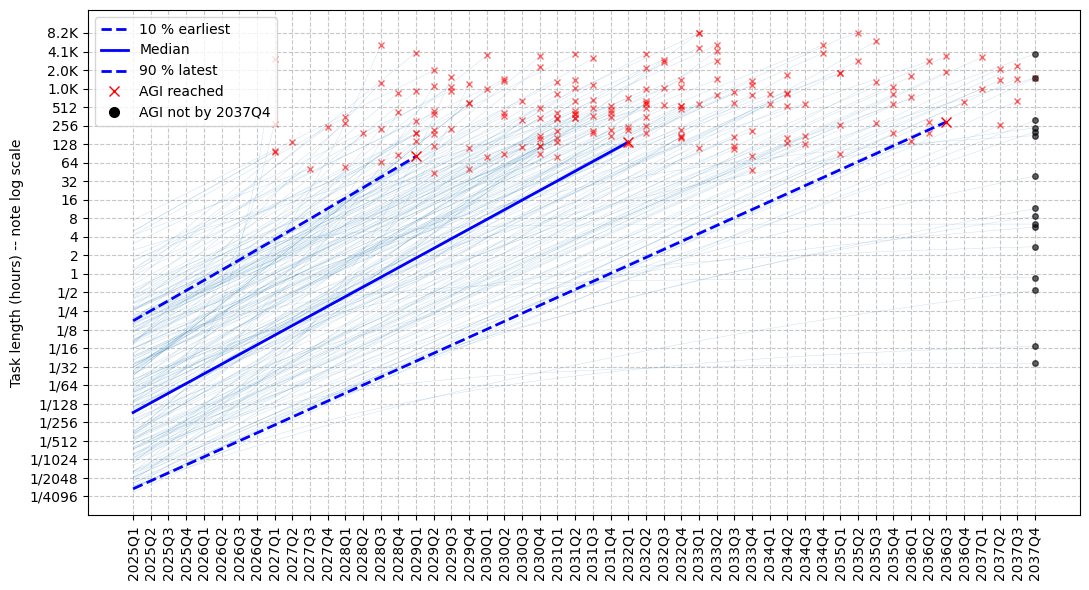

In [4]:
plot_exponential_growth(
    doubling_time_days=doubling_time,
    starting_hours=start_task_length,
    agi_task_length=agi_task_length,
    shift=shift,
    acceleration=acceleration,
    n_quarters=51,
    n_samples=100_000,
    n_traces=200,
    max_task_power=13,
    min_y_power=-15,
)